# Code for making predictions with and without news features

## Libraries/Data required

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Helper functions
from helper_functions import create_lag_df
from helper_functions import plot_ConfusionMatrix

data_dir = "data/" # Define data path

In [3]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
df['district'] = df['district'].str.replace("Center", "").str.replace("South", "").str.replace("North", "").str.replace("East", "").str.replace("West", "").str.strip()
df.set_index(["date", "district"], inplace=True) # Set index
numeric_columns = df.select_dtypes(include=['number'])
df = df.groupby(["date", "district"])[numeric_columns.columns].mean().reset_index()
df.set_index(["date", "district"], inplace=True) # Set index
df = df.round({'ipc': 0})
df

district_code      centx     centy    year  month  ipc  \
date       district                                                            
2007-01-01 Abiemnhom          136.0  29.130190  9.550939  2007.0    1.0  NaN   
           Akobo              114.0  32.853080  7.799214  2007.0    1.0  NaN   
           Anzara              86.0  28.205980  5.309739  2007.0    1.0  NaN   
           Aweil              120.6  27.139798  8.918846  2007.0    1.0  NaN   
           Awerial             99.0  31.229460  6.150162  2007.0    1.0  NaN   
...                             ...        ...       ...     ...    ...  ...   
2020-02-01 Wau                103.0  27.298230  7.284772  2020.0    2.0  3.0   
           Wulu               105.0  29.208890  6.200243  2020.0    2.0  2.0   
           Yambio              82.0  28.547290  5.124909  2020.0    2.0  3.0   
           Yei                 81.0  30.344540  4.252148  2020.0    2.0  3.0   
           Yirol              104.0  30.644715  6.594219  2020.0    2.0  4.0   

                       ha  ndvi_mean  ndvi_anom  rain_mean  ...   et_mean  \
date       district                                         ...             
2007-01-01 Abiemnhom  NaN   0.316412  100.55130   0.025810  ...  0.597288   
           Akobo      NaN   0.361317  114.89340   0.205147  ...  1.113290   
           Anzara     NaN   0.414913   94.84704   0.597445  ...  1.454028   
           Aweil      NaN   0.316901  101.51741   0.026128  ...  1.247115   
           Awerial    NaN   0.389172  106.39390   0.255114  ...  0.510219   
...                   ...        ...        ...        ...  ...       ...   
2020-02-01 Wau        0.0   0.370605  101.23200   0.597954  ...  0.122069   
           Wulu       0.0   0.374735  108.55950   0.665396  ...  0.125452   
           Yambio     0.0   0.468085  103.87600   1.465522  ...  2.018053   
           Yei        0.0   0.452878  105.17720   2.409410  ...  7.450696   
           Yirol      0.0   0.364909  118.40925   0.531674  ...  0.370820   

                       et_anom  count_violence  sum_fatalities  \
date       district                                              
2007-01-01 Abiemnhom  0.162672             0.0             0.0   
           Akobo      0.265087             0.0             0.0   
           Anzara    -1.051144             0.0             0.0   
           Aweil      0.455079             0.0             0.0   
           Awerial   -0.027814             0.0             0.0   
...                        ...             ...             ...   
2020-02-01 Wau       -0.105357             0.0             0.0   
           Wulu      -0.243994             1.0             1.0   
           Yambio     0.066441             0.0             0.0   
           Yei        4.531602             0.0             0.0   
           Yirol     -0.021709             1.5             9.5   

                      food_price_idx       area  cropland_pct         pop  \
date       district                                                         
2007-01-01 Abiemnhom        0.600941   2408.233      1.742261   18973.210   
           Akobo            0.616429   9027.626     10.046920  147537.900   
           Anzara           0.567126   6541.319     18.819290   71208.900   
           Aweil            0.600856   6197.357     14.740720  162124.700   
           Awerial          0.852021   4565.223      4.577788   51774.270   
...                              ...        ...           ...         ...   
2020-02-01 Wau             91.656480  19293.260      0.332958  177331.200   
           Wulu            83.059000  11894.780      0.032678   45158.500   
           Yambio          78.067220   8896.165     19.126490  197278.900   
           Yei             91.476050   6713.251     16.303490  288875.400   
           Yirol          101.200350   5239.805      1.472606   92836.865   

                      ruggedness_mean  pasture_pct  
date       district                                 
2007-01-01 A

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10112 entries, (Timestamp('2007-01-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   district_code    10112 non-null  float64
 1   centx            10112 non-null  float64
 2   centy            10112 non-null  float64
 3   year             10112 non-null  float64
 4   month            10112 non-null  float64
 5   ipc              2496 non-null   float64
 6   ha               1792 non-null   float64
 7   ndvi_mean        10112 non-null  float64
 8   ndvi_anom        10112 non-null  float64
 9   rain_mean        10112 non-null  float64
 10  rain_anom        10112 non-null  float64
 11  et_mean          10112 non-null  float64
 12  et_anom          10112 non-null  float64
 13  count_violence   10112 non-null  float64
 14  sum_fatalities   10112 non-null  float64
 15  food_price_idx   101

## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

In [5]:
# ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
# ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
# ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

/tmp/ipykernel_62441/480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


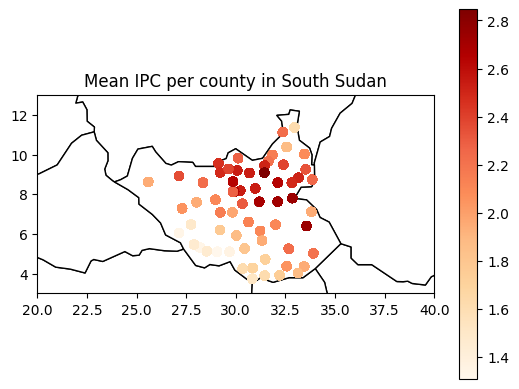

In [6]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [7]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom', 'ruggedness_mean',
                        'pop', 'cropland_pct', 'sum_fatalities', 'et_anom', 'rain_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
# df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
# df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns, len(df.columns) # View the newly created columns

(Index(['district_code', 'centx', 'centy', 'year', 'month', 'ipc', 'ha',
        'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
        'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
        'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct',
        'count_violence_lag_3', 'ndvi_anom_lag_3', 'ruggedness_mean_lag_3',
        'pop_lag_3', 'cropland_pct_lag_3', 'sum_fatalities_lag_3',
        'et_anom_lag_3', 'rain_anom_lag_3', 'food_price_idx_lag_3',
        'ipc_lag_1'],
       dtype='object'),
 31)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10112 entries, (Timestamp('2007-01-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district_code          10112 non-null  float64
 1   centx                  10112 non-null  float64
 2   centy                  10112 non-null  float64
 3   year                   10112 non-null  float64
 4   month                  10112 non-null  float64
 5   ipc                    2496 non-null   float64
 6   ha                     1792 non-null   float64
 7   ndvi_mean              10112 non-null  float64
 8   ndvi_anom              10112 non-null  float64
 9   rain_mean              10112 non-null  float64
 10  rain_anom              10112 non-null  float64
 11  et_mean                10112 non-null  float64
 12  et_anom                10112 non-null  float64
 13  count_violence        

In [9]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [10]:
# X = df.iloc[:, -10:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# # Initinalize empty lists to score scores
# mae_values = list()
# r2_values = list()

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     #Interpolate training data to generate more training points
#     # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # X_train.reset_index(level=0, drop=True, inplace=True)
#     # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # y_train.reset_index(level=0, drop=True, inplace=True)

#     model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
#     results = model.fit() # Get model results on training data
#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test) # Run model on test data
    
#     # Append results to respective lists
#     mae_values.append((y_pred - y_val['ipc']).abs().mean())
#     r2_values.append(results.rsquared)
    
#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
# print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
# print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [11]:
news_df = pd.read_csv(data_dir + "df_news_districted.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_df = news_df.drop(columns=['Unnamed: 0'])
# news_df = news_df.rename(columns = {'districts': 'district'})
# news_df = news_df.rename(columns={"location_article": "district"})

In [12]:
news_df.columns[2:-1]

Index(['hunger', 'refugees', 'humanitarian', 'Governance', 'Diplomacy',
       'Conflict', 'Crisis', 'Security', 'Society', 'Health', 'Development',
       'Education', 'Survival', 'International', 'Opposition', 'Welfare',
       'Media', 'Leadership'],
      dtype='object')

In [13]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date", 'district'])[column].sum()
        col = col.fillna(0)
        col = col.rolling(3).sum()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

In [14]:
len(news_df.columns[2:-1]) - 4

14

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

In [15]:
# country wide news features
news_features = create_news_features(news_df.columns[2:-1])

# news_features.plot();
news_features.iloc[500:565]

hunger  refugees  humanitarian  Governance  Diplomacy  \
date       district                                                          
2012-01-01 Tambura      9.0       9.0          12.0        12.0       12.0   
           Terekeka     9.0       9.0          12.0        12.0       12.0   
           Tonj         9.0       9.0          12.0        12.0       12.0   
           Torit        9.0       9.0          12.0        12.0       12.0   
           Twic         9.0       9.0          12.0        12.0       12.0   
...                     ...       ...           ...         ...        ...   
2012-02-01 Raja        25.0       9.0           7.0         6.0        6.0   
           Renk        25.0       9.0           7.0         6.0        6.0   
           Rubkona     24.0       9.0           7.0         6.0        6.0   
           Rumbek      24.0       9.0           6.0         6.0        6.0   
           Tambura     24.0       9.0           6.0         6.0        6.0   

                     Conflict  Crisis  Security  Society  Health  Development  \
date       district                                                             
2012-01-01 Tambura       12.0    12.0      27.0      6.0     9.0          3.0   
           Terekeka      12.0    12.0      27.0      6.0     9.0          3.0   
           Tonj          12.0    12.0      27.0      6.0     9.0          3.0   
           Torit         12.0    12.0      27.0      6.0     9.0          3.0   
           Twic          12.0    12.0      27.0      6.0     9.0          3.0   
...                       ...     ...       ...      ...     ...          ...   
2012-02-01 Raja          21.0    10.0       6.0     12.0    15.0         12.0   
           Renk          21.0    10.0       6.0     12.0    15.0         12.0   
           Rubkona       21.0    10.0       6.0     12.0    15.0         12.0   
           Rumbek        21.0     9.0       6.0     12.0    15.0         12.0   
           Tambura       21.0     9.0       6.0     12.0    15.0         12.0   

                     Education  Survival  International  Opposition  Welfare  \
date       district                                                            
2012-01-01 Tambura         6.0       6.0           12.0        18.0      6.0   
           Terekeka        6.0       6.0           12.0        18.0      6.0   
           Tonj            6.0       6.0           12.0        18.0      6.0   
           Torit           6.0       6.0           12.0        18.0      6.0   
           Twic            6.0       6.0           12.0        18.0      6.0   
...                        ...       ...            ...         ...      ...   
2012-02-01 Raja            9.0       3.0            6.0        15.0     18.0   
           Renk            9.0       3.0            6.0        15.0     18.0   
           Rubkona         9.0       3.0            6.0        15.0     18.0   
           Rumbek          9.0       3.0            6.0        15.0     18.0   
           Tambura         9.0       3.0            6.0        15.0     18.0   

                     Media  Leadership  
date       district                     
2012-01-01 Tambura     6.0         9.0  
           Terekeka    6.0         9.0  
           Tonj        6.0         9.0  
           Torit       6.0         9.0  
           Twic        6.0         9.0  
...                    ...         ...  
2012-02-01 Raja        9.0         3.0  
           Renk        9.0         3.0  
           Rubkona     9.0         3.0  
           Rumbek      9.0         3.0  
           Tambura     9.0         3.0  

[65 rows x 18 columns]

In [16]:
news_features.columns

Index(['hunger', 'refugees', 'humanitarian', 'Governance', 'Diplomacy',
       'Conflict', 'Crisis', 'Security', 'Society', 'Health', 'Development',
       'Education', 'Survival', 'International', 'Opposition', 'Welfare',
       'Media', 'Leadership'],
      dtype='object')

In [18]:
# # Plot the mean share of articles per ipc value for the different topics with thicker bars
# ax = combined.groupby("ipc")[["hunger", "refugees", "Diplomacy", "Crisis", "Security", "Education",
#                              "International", "Media", "Leadership"]].mean().plot(
#     kind="bar",
#     ylabel="Share of total articles",
#     title='Mean Share of Articles per IPC for Selected Topics',
#     width=0.8  # Adjust the width parameter to make the bars thicker
# )

# # Set the figure size (width, height) using the figsize parameter
# fig = ax.get_figure()
# fig.set_size_inches(8, 5)  # Adjust the width and height as needed

# # Show the plot
# plt.show()

## Predicting using news features

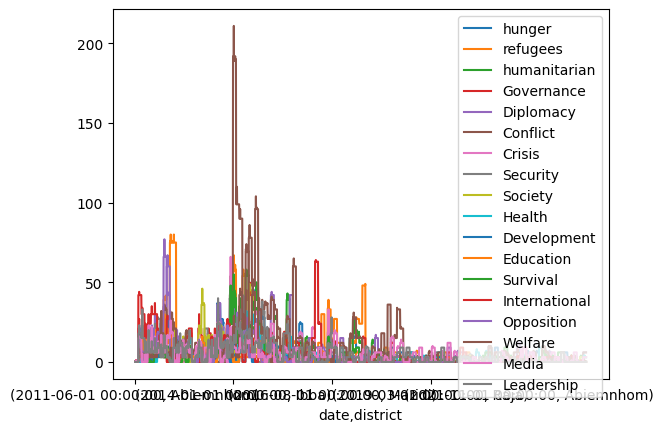

In [19]:
# df.sort_index(level=0, inplace=True)
news_features.plot();

In [20]:
# df.sort_index(level=0, inplace=True) # Sort DataFrame by date
# df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8192 entries, (Timestamp('2009-07-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district_code          8192 non-null   float64
 1   centx                  8192 non-null   float64
 2   centy                  8192 non-null   float64
 3   year                   8192 non-null   float64
 4   month                  8192 non-null   float64
 5   ipc                    2496 non-null   float64
 6   ha                     1792 non-null   float64
 7   ndvi_mean              8192 non-null   float64
 8   ndvi_anom              8192 non-null   float64
 9   rain_mean              8192 non-null   float64
 10  rain_anom              8192 non-null   float64
 11  et_mean                8192 non-null   float64
 12  et_anom                8192 non-null   float64
 13  count_violence         

In [22]:
for i in news_features.columns:
    df[i] = df[i].fillna(0)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8192 entries, (Timestamp('2009-07-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district_code          8192 non-null   float64
 1   centx                  8192 non-null   float64
 2   centy                  8192 non-null   float64
 3   year                   8192 non-null   float64
 4   month                  8192 non-null   float64
 5   ipc                    2496 non-null   float64
 6   ha                     1792 non-null   float64
 7   ndvi_mean              8192 non-null   float64
 8   ndvi_anom              8192 non-null   float64
 9   rain_mean              8192 non-null   float64
 10  rain_anom              8192 non-null   float64
 11  et_mean                8192 non-null   float64
 12  et_anom                8192 non-null   float64
 13  count_violence         

In [24]:
# from sklearn.datasets import make_hastie_10_2
# from sklearn.metrics import accuracy_score, make_scorer
# from sklearn.model_selection import GridSearchCV
# from sklearn import linear_model


# # df_prep = df.copy().iloc[:, [7] + list(range(-10, 0))].dropna()


# X = df.iloc[:, -14:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# # Initinalize empty lists to score scores
# mae_values = list()
# r2_values = list()

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
#     X_train = X_train.dropna(axis=1, how='all').copy()
#     X_test = X_test[X_train.columns]
    
#     #Interpolate training data to generate more training points
#     # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # X_train.reset_index(level=0, drop=True, inplace=True)
#     # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # y_train.reset_index(level=0, drop=True, inplace=True)
    
#     model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
#     results = model.fit() # Get model results on training data

#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test) # Run model on test data
    
#     # Append results to respective lists
#     mae_values.append((y_pred - y_val['ipc']).abs().mean())
#     r2_values.append(results.rsquared)

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
# print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
# print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [25]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [26]:
# X = df.iloc[:, -10:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
# acc_values = list() # Initinalize empty lists to score accuracy scores

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
#     y_binary = y > 2 # Convert y to binary variable
#     y_binary[y.isna()] = pd.NA # Conserve NaN values
#     y_binary = y_binary.astype("float32") # Convert y to float

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
#     #Interpolate training data to generate more training points
#     X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     X_train.reset_index(level=0, drop=True, inplace=True)
#     y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     y_train.reset_index(level=0, drop=True, inplace=True)
    
#     cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
#     model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
#     results = model.fit() # Get model results on training data
#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test[cols]) # Run model on test data

#     # Convert prediction and validation to boolean
#     y_pred = y_pred.round().astype(bool)
#     y_val = y_val.round().astype(bool)

#     # Drop all rows from prediction and validation where validation is null
#     y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
#     y_val.dropna(inplace=True)

#     acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
# print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc
# df.info()

In [27]:
df.columns

Index(['district_code', 'centx', 'centy', 'year', 'month', 'ipc', 'ha',
       'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
       'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct',
       'count_violence_lag_3', 'ndvi_anom_lag_3', 'ruggedness_mean_lag_3',
       'pop_lag_3', 'cropland_pct_lag_3', 'sum_fatalities_lag_3',
       'et_anom_lag_3', 'rain_anom_lag_3', 'food_price_idx_lag_3', 'ipc_lag_1',
       'hunger', 'refugees', 'humanitarian', 'Governance', 'Diplomacy',
       'Conflict', 'Crisis', 'Security', 'Society', 'Health', 'Development',
       'Education', 'Survival', 'International', 'Opposition', 'Welfare',
       'Media', 'Leadership'],
      dtype='object')

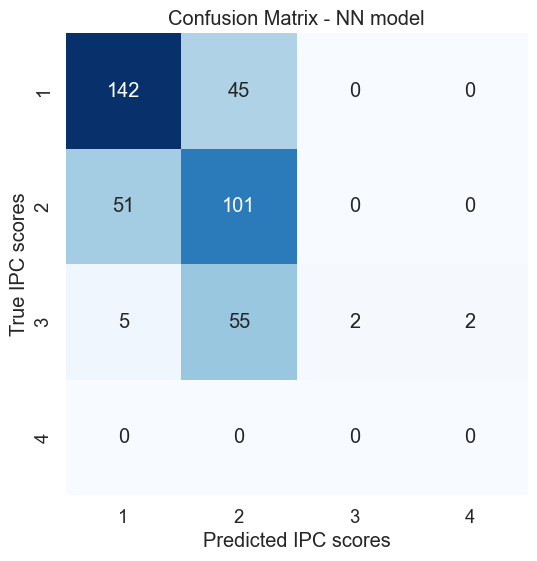

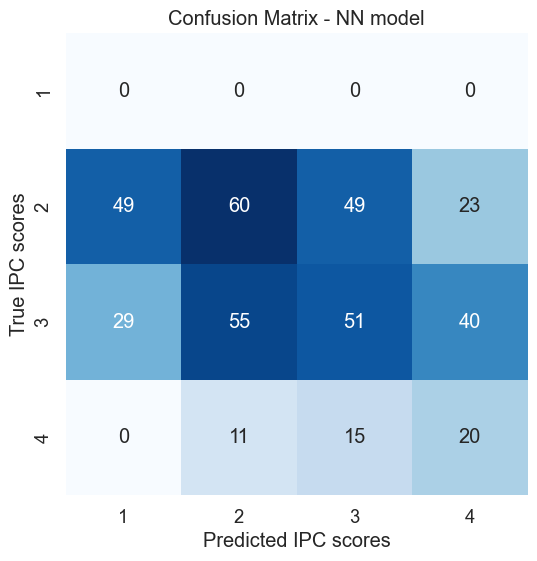

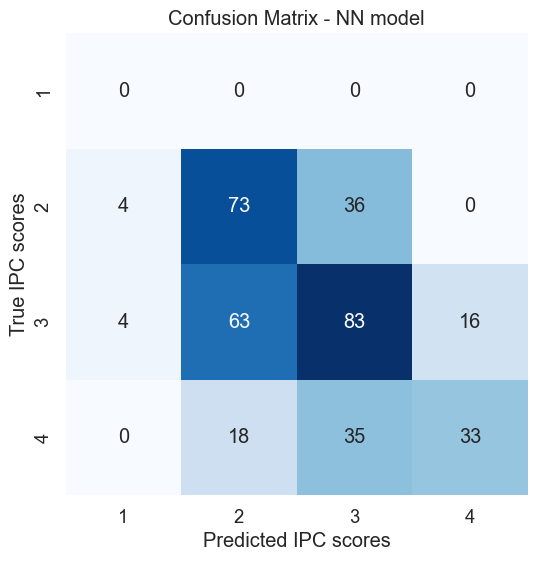

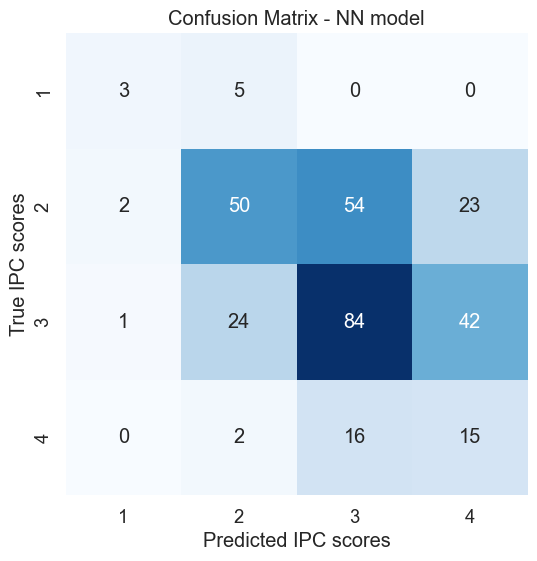

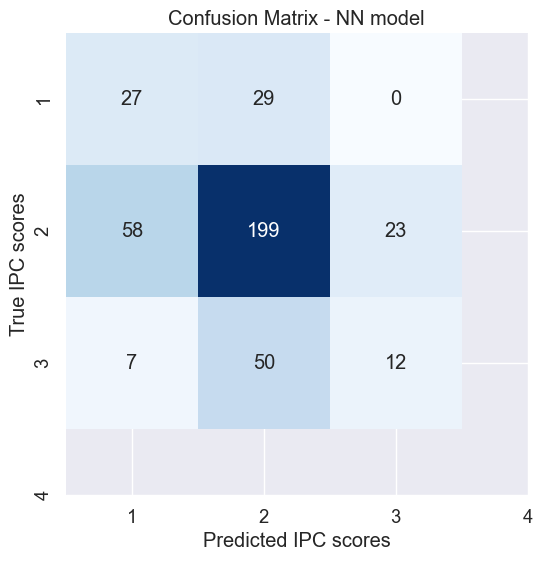

Mean MAE: 0.65
Mean R2: 0.55
Mean Accuracy: 47.21%
Mean Weighted F1: 0.479


In [43]:
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge


# # df_prep = df.copy().iloc[:, [5] + list(range(-16, 0))].dropna()


X = df.iloc[:, -28:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

y = y[X['ipc_lag_1'].notnull()]
X = X[X['ipc_lag_1'].notnull()]

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()
accuracy_values = list()
f1_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    # model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    model = linear_model.Ridge(alpha=3)

    model.fit(X_train, y_train) # Get model results on training data

    y_pred = np.round(model.predict(X_test).T[0]) # Run model on test data

    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())

    cur_r2 = r2_score(y_pred=model.predict(X_train),
                      y_true=y_train['ipc'])
    r2_values.append(cur_r2)

    accuracy_values.append(accuracy_score(y_pred=y_pred,
                    y_true=y_val['ipc']))

    f1_values.append(f1_score(y_pred=y_pred,
                    y_true=y_val['ipc'], average='weighted'))

    plot_ConfusionMatrix(predicted_labels = y_pred, true_labels = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
print(f"Mean Accuracy: {100*np.mean(accuracy_values):.2f}%") # Print Mean Accuracy
print(f"Mean Weighted F1: {np.mean(f1_values):.3f}") # Print Mean Weighted F1

In [37]:
y_pred.T[0]

2.0

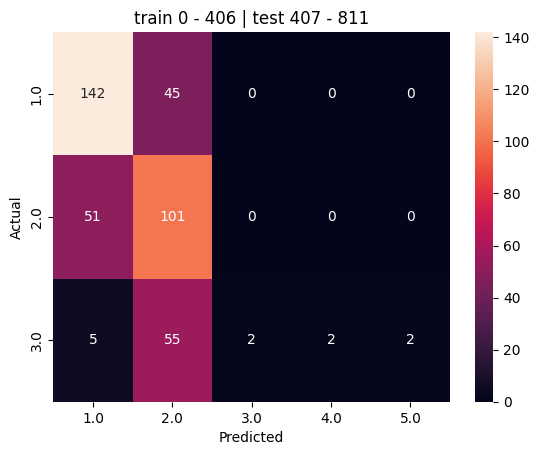

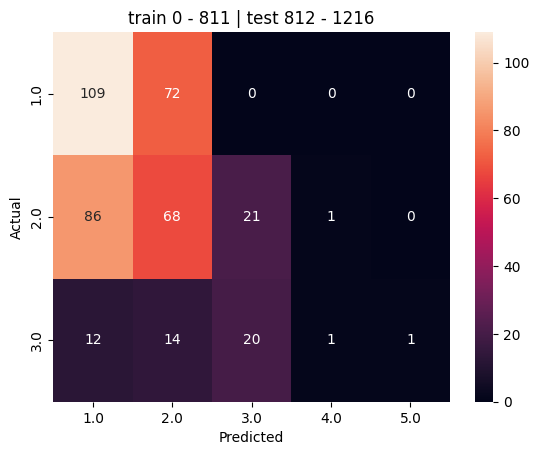

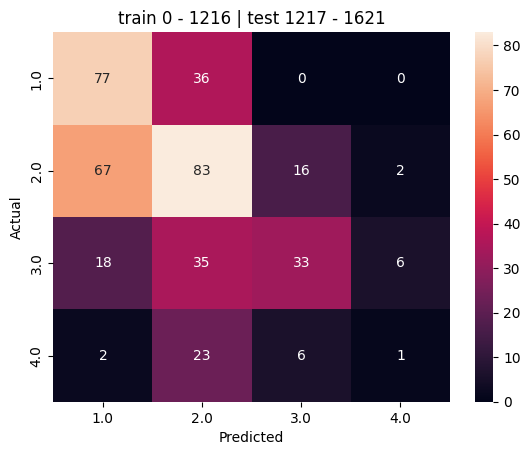

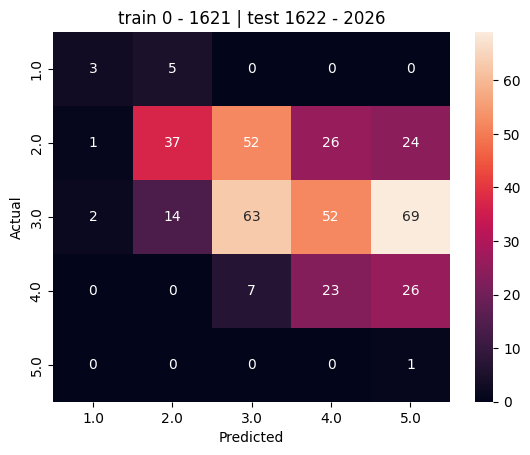

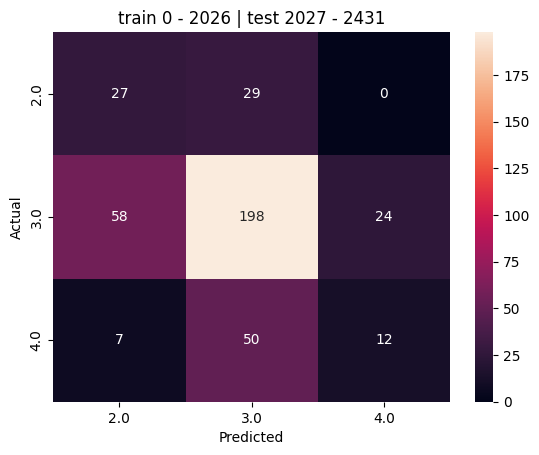

Mean MAE: 0.705
Mean R2: nan
Mean accuracy: 46.47%
Mean weighted f1: 0.474


/home/egor/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/egor/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression


# df_prep = df.copy().iloc[:, [5] + list(range(-16, 0))].dropna()


# X = df.iloc[:, -28:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()
f1_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    # X_train.reset_index(level=0, drop=True, inplace=True)
    # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    # y_train.reset_index(level=0, drop=True, inplace=True)
    
    # model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    model = linear_model.Ridge()

    model.fit(X_train, y_train) # Get model results on training data

    # print(results.summary()) # Print model summary

    y_pred = np.round(model.predict(X_test).T[0]) # Run model on test data
    # y_pred = y_pred.T[0]

    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())

    # cur_r2 = results.rsquared
    # cur_r2 = r2_score(y_pred=results.predict(X_train),
    #                   y_true=y_train['ipc'])
    # r2_values.append(cur_r2)

    accuracy_values.append(accuracy_score(y_pred=y_pred,
                      y_true=y_val['ipc']))

    f1_values.append(f1_score(y_pred=y_pred,
                      y_true=y_val['ipc'], average='weighted'))

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.3f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.3f}") # Print R2
print(f"Mean accuracy: {100*np.mean(accuracy_values):.2f}%") # Print R2
print(f"Mean weighted f1: {np.mean(f1_values):.3f}") # Print R2

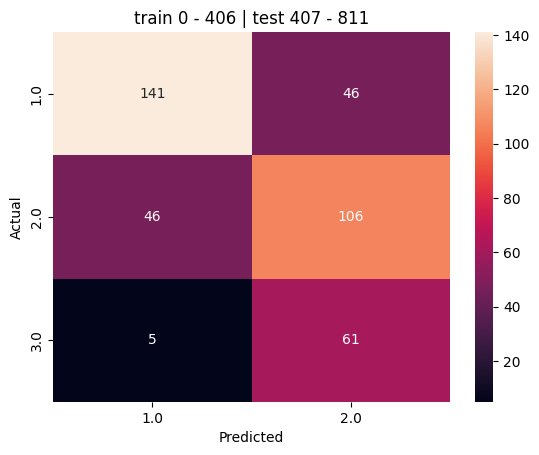

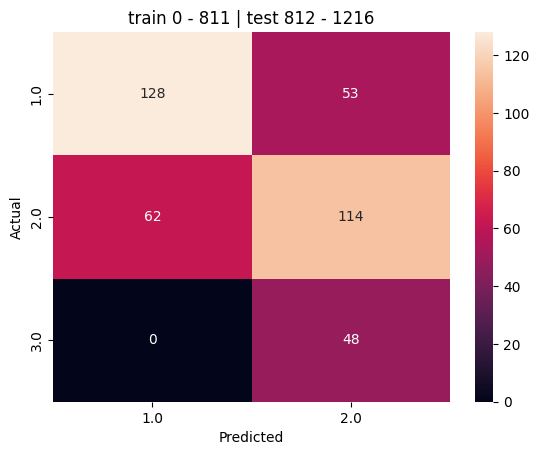

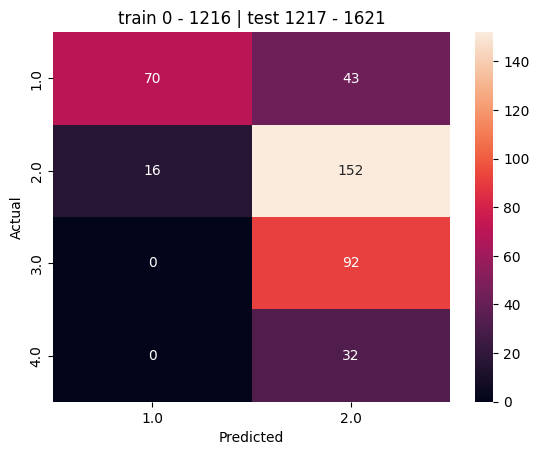

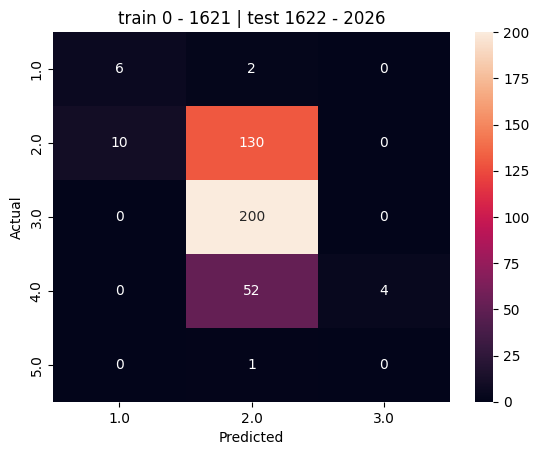

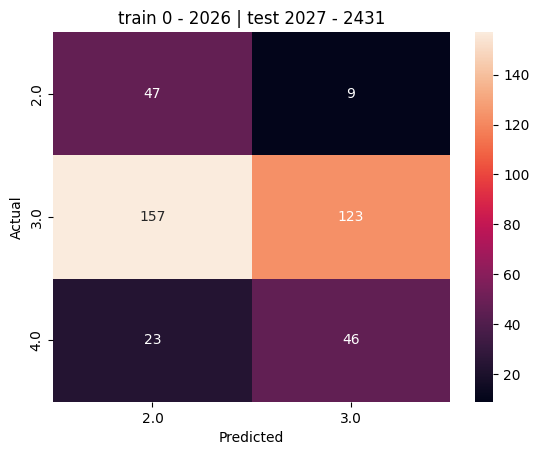

Mean MAE: 0.554
Mean R2: nan
Mean accuracy: 50.22%
Mean weighted f1: 0.435


/home/egor/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/egor/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import r2_score
import xgboost as xgb



# df_prep = df.copy().iloc[:, [5] + list(range(-16, 0))].dropna()


# X = df.iloc[:, -28:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()
f1_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    # X_train.reset_index(level=0, drop=True, inplace=True)
    # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    # y_train.reset_index(level=0, drop=True, inplace=True)
    
    # model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data


    # Create a DMatrix for XGBoost (XGBoost uses its own data structure)
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # Specify the XGBoost parameters (you can adjust these as needed)
    params = {
        "objective": "reg:squarederror",  # Regression task
        "max_depth": 3,  # Maximum depth of the tree
        "eta": 0.01,  # Learning rate
        "subsample": 0.7,  # Fraction of data to randomly sample for each tree
        "colsample_bytree": 0.7,  # Fraction of features to randomly sample for each tree
    }

    # Train the XGBoost model
    num_round = 100  # Number of boosting rounds (you can adjust this)
    model = xgb.train(params, dtrain, num_round)

    # Create a DMatrix for X_test
    dtest = xgb.DMatrix(X_test)

    # Make predictions on the test data
    y_pred = np.round(model.predict(dtest))

    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())

    # cur_r2 = results.rsquared
    # cur_r2 = r2_score(y_pred=results.predict(X_train),
    #                   y_true=y_train['ipc'])
    # r2_values.append(cur_r2)

    accuracy_values.append(accuracy_score(y_pred=y_pred,
                      y_true=y_val['ipc']))

    f1_values.append(f1_score(y_pred=y_pred,
                      y_true=y_val['ipc'], average='weighted'))

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.3f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.3f}") # Print R2
print(f"Mean accuracy: {100*np.mean(accuracy_values):.2f}%") # Print R2
print(f"Mean weighted f1: {np.mean(f1_values):.3f}") # Print R2

In [ ]:
# # Get the mean share of articles per ipc for the different topics
# combined = (
#     pd.DataFrame(y['ipc'])
#     .join(news_df.groupby(["date"])["hunger"].mean())
#     .join(news_df.groupby(["date"])["refugees"].mean())
#     .join(news_df.groupby(["date"])["conflict"].mean())
#     .join(news_df.groupby(["date"])["humanitarian"].mean())
# )


# # Plot the mean share of articles per ipc value for the different topics
# combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
#     kind="bar", ylabel="Share of total articles"
# );

In [ ]:
len(X)

2432

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69)



# Normalize your data (optional, but recommended)
scaler = StandardScaler()
X_train_model = scaler.fit_transform(X_train.values)
X_test_model = scaler.transform(X_test.values)

# Convert data to PyTorch tensors
X_train_model = torch.FloatTensor(X_train_model)
X_test_model = torch.FloatTensor(X_test_model)
y_train_model = torch.LongTensor(y_train.values)
y_test_model = torch.LongTensor(y_test.values)

# Subtract 1 from the target labels to make them range from 0 to 4
y_train_model = torch.LongTensor([label - 1 for label in y_train_model]).unsqueeze(dim=1)
y_test_model = torch.LongTensor([label - 1 for label in y_test_model]).unsqueeze(dim=1)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_model, y_train_model)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_model, y_test_model)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1945 entries, (Timestamp('2019-02-01 00:00:00'), 'Wulu') to (Timestamp('2016-02-01 00:00:00'), 'Longchuk')
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   const                  1945 non-null   float64
 1   count_violence_lag_3   1945 non-null   float64
 2   ndvi_anom_lag_3        1945 non-null   float64
 3   ruggedness_mean_lag_3  1945 non-null   float64
 4   pop_lag_3              1945 non-null   float64
 5   cropland_pct_lag_3     1945 non-null   float64
 6   sum_fatalities_lag_3   1945 non-null   float64
 7   et_anom_lag_3          1945 non-null   float64
 8   rain_anom_lag_3        1945 non-null   float64
 9   food_price_idx_lag_3   1945 non-null   float64
 10  ipc_lag_1              1945 non-null   float64
 11  hunger                 1945 non-null   float64
 12  refugees               1945 non-null   float64
 13  humanitarian           19

In [ ]:
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import plotext
from pathlib import Path
from typing import List


class HungerModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HungerModel, self).__init__()
        self.linear_layer_1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.linear_layer_2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.linear_layer_1(x)
        x = self.relu(x)
        x = self.linear_layer_2(x)
        return x

# Define class weights based on ordinal distance
class_weights = torch.tensor([1.0, 1.0, 2.0, 2.0, 2.0])

input_size = X_train.shape[1]
num_classes = 5

model = HungerModel(input_size, num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 1200
best_loss = 10000
mean_losses_train: List[torch.Tensor] = []
mean_losses_test: List[torch.Tensor] = []


for epoch in tqdm(range(num_epochs)):
    model.train()
    curr_losses_train: List[torch.Tensor] = []
    curr_losses_test: List[torch.Tensor] = []
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()
        train_loss = criterion(outputs, labels)
        curr_losses_train.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
    mean_losses_train.append(sum(curr_losses_train) / len(curr_losses_train))

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            outputs = model(inputs)
            labels = labels.squeeze()
            test_loss = criterion(outputs, labels)
            curr_losses_test.append(test_loss.item())
        mean_losses_test.append(sum(curr_losses_test) / len(curr_losses_test))
    # Print training loss for each epoch
    


    if mean_losses_test[-1] < best_loss:
        best_loss = mean_losses_test[-1]
        # Save the model checkpoint
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {best_loss:.4f}')
        
model = HungerModel(input_size, num_classes)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set the model to evaluation mode
 

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [1/1200] Loss: 1.5786
Epoch [2/1200] Loss: 1.5451
Epoch [3/1200] Loss: 1.5129
Epoch [4/1200] Loss: 1.4834
Epoch [5/1200] Loss: 1.4550
Epoch [6/1200] Loss: 1.4277
Epoch [7/1200] Loss: 1.4016
Epoch [8/1200] Loss: 1.3761
Epoch [9/1200] Loss: 1.3513
Epoch [10/1200] Loss: 1.3279
Epoch [11/1200] Loss: 1.3050
Epoch [12/1200] Loss: 1.2832
Epoch [13/1200] Loss: 1.2624
Epoch [14/1200] Loss: 1.2423
Epoch [15/1200] Loss: 1.2230
Epoch [16/1200] Loss: 1.2049
Epoch [17/1200] Loss: 1.1878
Epoch [18/1200] Loss: 1.1715
Epoch [19/1200] Loss: 1.1559
Epoch [20/1200] Loss: 1.1413
Epoch [21/1200] Loss: 1.1274
Epoch [22/1200] Loss: 1.1138
Epoch [23/1200] Loss: 1.1011
Epoch [24/1200] Loss: 1.0894
Epoch [25/1200] Loss: 1.0778
Epoch [26/1200] Loss: 1.0671
Epoch [27/1200] Loss: 1.0566
Epoch [28/1200] Loss: 1.0465
Epoch [29/1200] Loss: 1.0368
Epoch [30/1200] Loss: 1.0277
Epoch [31/1200] Loss: 1.0194
Epoch [32/1200] Loss: 1.0106
Epoch [33/1200] Loss: 1.0028
Epoch [34/1200] Loss: 0.9951
Epoch [35/1200] Loss: 0

HungerModel(
  (linear_layer_1): Linear(in_features=29, out_features=64, bias=True)
  (relu): ReLU()
  (linear_layer_2): Linear(in_features=64, out_features=5, bias=True)
)

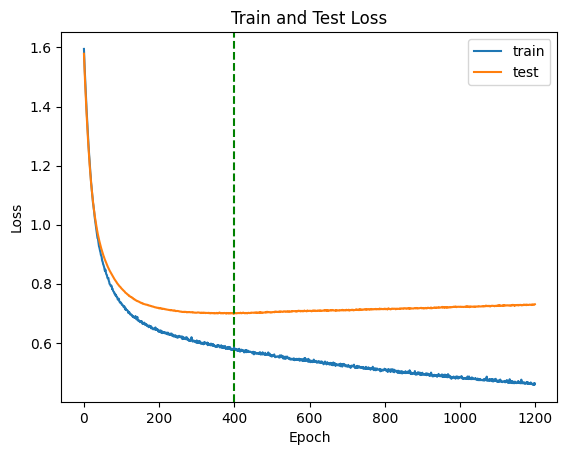

In [ ]:
sns.lineplot(x=range(len(mean_losses_train)), y=mean_losses_train, label="train")
sns.lineplot(x=range(len(mean_losses_test)), y=mean_losses_test, label="test")

# Set plot labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss")

# Add a legend
plt.legend()

min_test_loss_epoch = mean_losses_test.index(min(mean_losses_test))
# plt.axvline(x=mean_losses_test.index(min(mean_losses_test)), color='red', linestyle='--', label="Lowest Test Loss")
plt.axvline(x=min_test_loss_epoch, color='green', linestyle='--', label="Lowest Test Loss")
# plt.text(min_test_loss_epoch, mean_losses_test[min_test_loss_epoch], f"Min Epoch: {min_test_loss_epoch}", fontsize=12, ha='right')
# Show the plot
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, _ = batch
        outputs = model(inputs)
        # Apply softmax and get predicted classes using argmax
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        # Print predicted classes (1 to 5)
        # print(predicted_classes.numpy())


Confusion Matrix:
[[123  36   2   0]
 [ 31 100  30   0]
 [  1  32  97   3]
 [  0   0  26   6]]
Accuracy: 0.6694045174537988
F1 Score: 0.6615275459955255


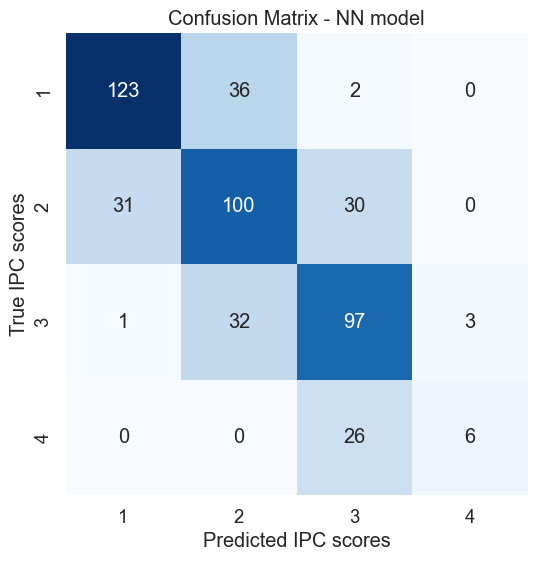

Accuracy: 0.6694045174537988
F1 Score: 0.6615275459955255
Mean Squared Error (MSE): 0.3490759753593429
Mean Absolute Error (MAE): 0.33675564681724846


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probabilities = []  # Added for MSE and MAE

combined_dataset = ConcatDataset([
    TensorDataset(X_train_model, y_train_model),
    TensorDataset(X_test_model, y_test_model)
])

combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        # Apply softmax and get predicted classes using argmax
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted_classes.numpy())

        predicted_probabilities.extend(probabilities.numpy())  # Added for MSE and MAE

# Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
confusion = confusion[:num_classes - 1, :num_classes - 1]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Confusion Matrix:")
print(confusion)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
# Calculate MSE and MAE
# Calculate MSE and MAE

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size if needed
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=[str(i+1) for i in range(num_classes - 1)],
            yticklabels=[str(i+1) for i in range(num_classes - 1)])
plt.xlabel('Predicted IPC scores')
plt.ylabel('True IPC scores')
plt.title('Confusion Matrix - NN model')
plt.show()


print("Accuracy:", accuracy)
print("F1 Score:", f1)
# ... (remaining code for MSE and MAE)


# Convert true_labels to one-hot encoded format
num_classes = 5  # Assuming you have 5 classes
true_labels_onehot = np.zeros((len(true_labels), num_classes))
true_labels_onehot[np.arange(len(true_labels)), true_labels] = 1

mse = np.mean(np.square(np.array(predicted_labels) - [i[0] for i in true_labels]))
mae = np.mean(np.abs(np.array(predicted_labels) - [i[0] for i in true_labels]))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

In [ ]:
for i in test_loader:
    print(i)
    break

[tensor([[ 0.0000,  0.3543,  1.4029,  ..., -0.7948,  3.5216,  2.2211],
        [ 0.0000, -0.2266, -0.3258,  ..., -0.7948,  0.7636, -0.8302],
        [ 0.0000, -0.4589, -0.4864,  ..., -0.4464, -0.8911,  0.3903],
        ...,
        [ 0.0000, -0.3427,  0.2108,  ..., -0.7948, -0.8911, -0.8302],
        [ 0.0000, -0.3427, -2.2478,  ..., -0.7948, -0.8911, -0.8302],
        [ 0.0000, -0.4589,  0.6313,  ...,  2.6892,  0.9475,  0.5937]]), tensor([[2],
        [1],
        [1],
        [2],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [2],
        [0],
        [1],
        [1],
        [1],
        [0],
        [2],
        [2],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [3],
        [2],
        [2],
        [1],
        [3],
        [2],
        [2],
        [2],
        [0],
        [1],
        [0],
        [1],
        [3],
        [0],
        [0],
     

In [ ]:
max(true_labels)

array([3])

<Axes: xlabel='ipc', ylabel='Density'>

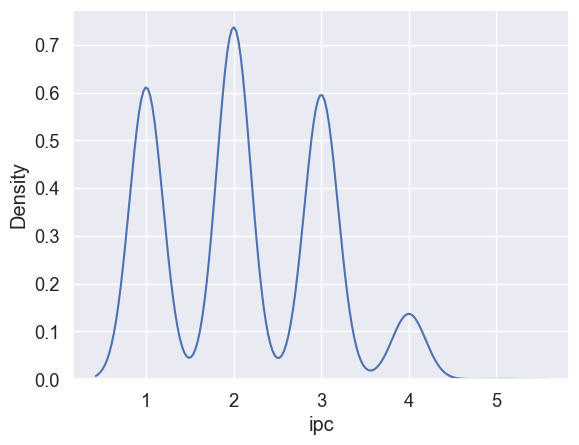

In [ ]:
from seaborn import kdeplot, histplot

kdeplot(y[y['ipc'].notnull()]['ipc'])

5.0


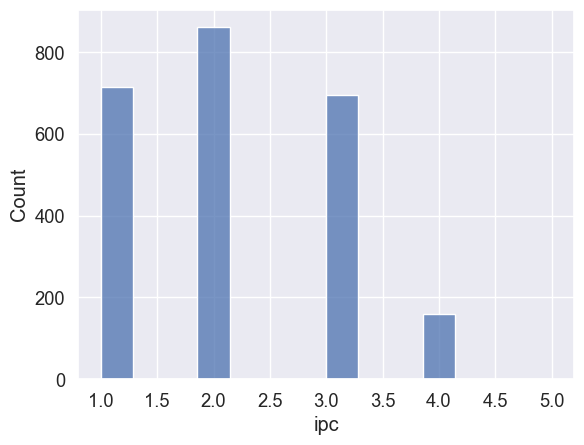

In [ ]:
histplot(y['ipc'])
print(y['ipc'].max())

In [ ]:
for i in predicted_probabilities[1]:
    print(f"{100*i:.2f}%", end=' ')

49.71% 49.57% 0.71% 0.00% 0.00% 

In [ ]:
predict_prob_list = np.ndarray(len(predicted_probabilities))
predict_class_list = np.ndarray(len(predicted_probabilities))

for i in range(len(predicted_probabilities)):
    if i % 10 == 0:
        print()
    predict_prob_list[i] = predicted_probabilities[i].max()
    print(f"{100*predict_prob_list[i]:.2f}%", end=" ")


89.31% 49.71% 70.24% 83.26% 95.63% 71.00% 85.33% 87.92% 50.47% 59.76% 
87.15% 96.02% 56.75% 83.36% 81.19% 66.75% 76.15% 84.43% 59.06% 46.29% 
62.44% 58.28% 86.09% 72.06% 54.92% 60.06% 84.74% 58.54% 70.18% 80.14% 
86.62% 90.10% 69.33% 86.69% 62.81% 79.06% 84.39% 70.65% 60.68% 53.08% 
60.83% 85.03% 83.89% 88.46% 80.15% 65.00% 87.46% 55.87% 76.37% 64.99% 
88.45% 79.31% 60.70% 81.22% 73.39% 51.35% 61.56% 57.30% 59.26% 48.74% 
63.44% 60.47% 70.28% 66.43% 79.15% 82.36% 55.25% 72.55% 86.10% 52.11% 
51.07% 92.06% 71.23% 65.23% 45.45% 72.25% 70.56% 88.78% 82.22% 74.38% 
68.55% 76.01% 69.34% 62.62% 75.97% 66.24% 77.70% 52.83% 73.14% 79.82% 
71.59% 63.29% 95.85% 58.62% 86.12% 44.70% 77.86% 83.33% 55.17% 83.77% 
61.66% 81.18% 75.91% 86.91% 76.65% 79.68% 87.54% 66.67% 68.24% 71.64% 
73.60% 67.63% 50.20% 60.85% 81.74% 80.63% 81.45% 65.37% 82.77% 52.19% 
84.39% 75.81% 86.56% 77.43% 66.32% 62.37% 66.10% 63.41% 74.22% 81.99% 
98.75% 60.63% 70.07% 50.22% 56.66% 90.19% 57.79% 84.01% 82.39% 68.70% 
86.73

<Figure size 800x500 with 0 Axes>

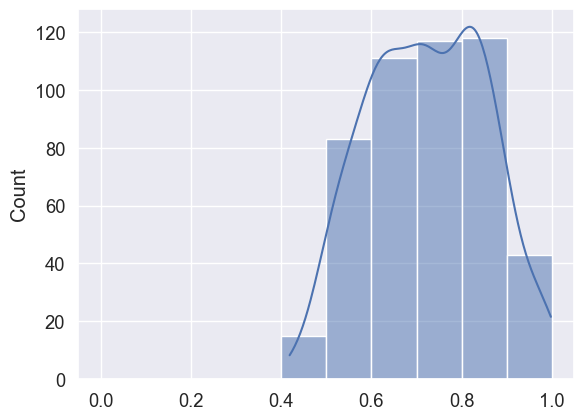

<Figure size 800x500 with 0 Axes>

In [ ]:
histplot(predict_prob_list, bins=[i/10 for i in range(11)], kde=True);
plt.figure(figsize=(8, 5))

In [ ]:
len(predict_prob_list), len(true_labels), len(predicted_labels)

(487, 487, 487)

In [ ]:
# for i in range(len(true_labels)):
#     true_labels[i] = true_labels[i][0]

predicted_labels[0]

2

In [ ]:
df_confidence = pd.DataFrame({'true_val': true_labels, 'pred_val': predicted_labels, 'pred_prob': predict_prob_list})
df_confidence = df_confidence[(df_confidence['pred_prob'] > 0) & (df_confidence['pred_prob'] < 1)]
df_confidence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 486
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   true_val   487 non-null    object 
 1   pred_val   487 non-null    int64  
 2   pred_prob  487 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 15.2+ KB


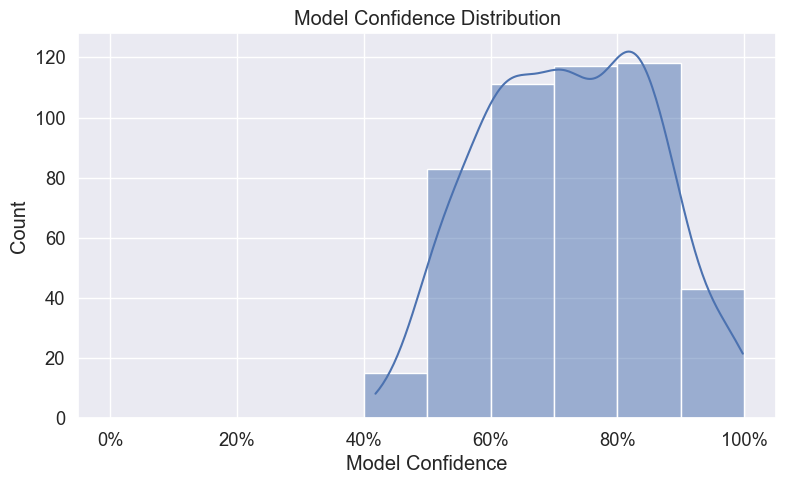

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the figure size
plt.figure(figsize=(9, 5))  # Adjust the width and height as needed
# Create your histogram plot
sns.histplot(df_confidence['pred_prob'], bins=[i/10 for i in range(11)], kde=True)

# Add xlabel, ylabel, and title
plt.xlabel('Model Confidence')
plt.ylabel('Count')
plt.title('Model Confidence Distribution')

# Update the x-axis tick labels to display every 20%
x_ticks = [i/5 for i in range(6)]  # 0.0, 0.2, 0.4, 0.6, 0.8, 1.0
x_labels = [f'{int(x*100)}%' for x in x_ticks]
plt.xticks(x_ticks, x_labels)
# Display the plot
plt.show()

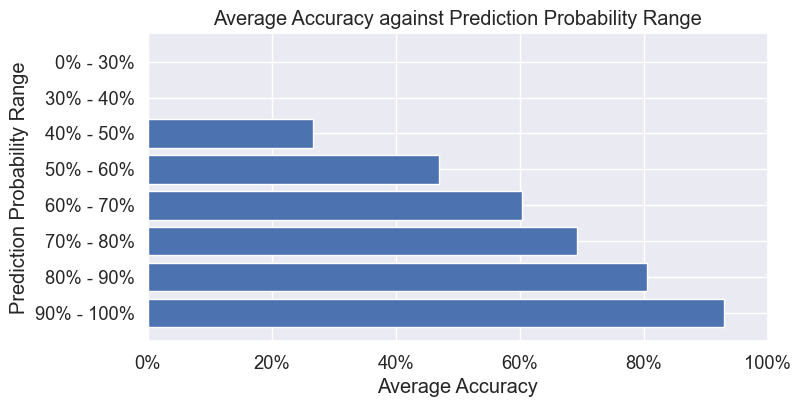

In [ ]:
# Define the probability ranges
probability_ranges = [(1.0, 0.9), (0.9, 0.8), (0.8, 0.7), (0.7, 0.6), (0.6, 0.5), (0.5, 0.4), (0.4, 0.3), (0.3, 0.0)]

# Calculate accuracy for each probability range
accuracies = []
for range_start, range_end in probability_ranges:
    subset = df_confidence[(df_confidence['pred_prob'] >= range_end) & (df_confidence['pred_prob'] <= range_start)]
    if len(subset) > 0:
        accuracy = np.sum(subset['true_val'] == subset['pred_val']) / len(subset)
        accuracies.append(accuracy)
    else:
        accuracies.append(0.0)

# Create the histogram
plt.figure(figsize=(8, 4))
plt.barh([f"{int(range_end*100)}% - {int(range_start*100)}%" for range_start, range_end in probability_ranges], accuracies)
plt.xlabel('Average Accuracy')
plt.ylabel('Prediction Probability Range')
plt.title('Average Accuracy against Prediction Probability Range')
plt.xlim(0, 1)

# Define a function to format the x-axis ticks as percentages
def percentage_formatter(x, pos):
    return f"{int(x * 100)}%"

# Modify the x-axis ticks to display as percentages
x_ticks_percentages = [f"{int(x*100)}%" for x in plt.xticks()[0]]
plt.xticks(plt.xticks()[0], x_ticks_percentages)


plt.show()

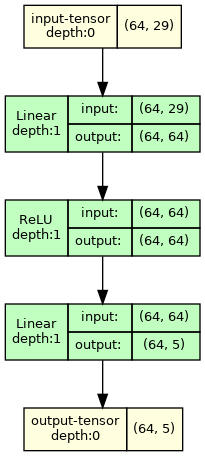

In [ ]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

model_graph = draw_graph(HungerModel(input_size, num_classes), input_size=(64, X_train.shape[1]), device='meta', graph_name='RecursiveNet',
    roll=True, expand_nested=True)
model_graph.visual_graph

In [ ]:
print(len(predict_prob_list))
y_test

487


,,ipc
date,district,
2015-01-01,Panyikang,3.0
2013-04-01,Tonj,2.0
2012-07-01,Cueibet,2.0
2016-06-01,Kapoeta,3.0
2013-04-01,Torit,2.0
...,...,...
2018-02-01,Awerial,3.0
2016-02-01,Rumbek,2.0
2017-02-01,Mayendit,4.0


In [ ]:
import statistics
prob_per_district = dict()

for i in y_test.index:
    prob_per_district[i[1]] = round(statistics.mean(predict_prob_list[y_test.index.get_level_values('district') == i[1]]) * 100, 2)

In [ ]:
dict(sorted(prob_per_district.items(), key=lambda item: -item[1]))

{'Lainya': 88.73,
 'Morobo': 85.65,
 'Kajo Keji': 85.13,
 'Maridi': 85.0,
 'Magwi': 83.42,
 'Yambio': 82.91,
 'Juba': 82.0,
 'Ibba': 81.8,
 'Torit': 81.07,
 'Mundri': 79.98,
 'Yei': 78.53,
 'Mvolo': 77.83,
 'Fashoda': 77.79,
 'Fangak': 77.73,
 'Budi': 77.46,
 'Panyikang': 77.32,
 'Manyo': 76.59,
 'Panyijiar': 76.3,
 'Yirol': 76.05,
 'Nagero': 75.36,
 'Ikotos': 75.15,
 'Rubkona': 75.06,
 'Tambura': 74.5,
 'Anzara': 74.32,
 'Ezo': 73.94,
 'Duk': 73.93,
 'Leer': 73.82,
 'Baliet': 73.74,
 'Uror': 73.47,
 'Ulang': 72.97,
 'Maiwut': 72.34,
 'Abiemnhom': 72.16,
 'Jur River': 72.0,
 'Kapoeta': 71.87,
 'Nasir': 71.85,
 'Maban': 71.54,
 'Melut': 71.06,
 'Mayendit': 70.52,
 'Lafon': 69.95,
 'Wulu': 69.82,
 'Malakal': 69.76,
 'Renk': 69.6,
 'Terekeka': 69.26,
 'Raja': 69.1,
 'Gogrial': 69.05,
 'Bor': 68.54,
 'Pochalla': 68.54,
 'Ayod': 68.46,
 'Akobo': 67.82,
 'Aweil': 67.67,
 'Mayom': 67.19,
 'Guit': 67.07,
 'Cueibet': 66.7,
 'Wau': 65.79,
 'Rumbek': 65.54,
 'Pariang': 65.45,
 'Longchuk': 64.66,


MultiIndex([('2015-01-01', 'Panyikang'),
            ('2013-04-01',      'Tonj'),
            ('2012-07-01',   'Cueibet'),
            ('2016-06-01',   'Kapoeta'),
            ('2013-04-01',     'Torit'),
            ('2011-01-01',      'Budi'),
            ('2015-10-01',  'Terekeka'),
            ('2010-01-01',    'Fangak'),
            ('2013-04-01',    'Rumbek'),
            ('2011-04-01',  'Mayendit'),
            ...
            ('2012-10-01',    'Ikotos'),
            ('2019-02-01',       'Yei'),
            ('2010-01-01',      'Ibba'),
            ('2011-10-01',     'Pibor'),
            ('2019-10-01',      'Koch'),
            ('2018-02-01',   'Awerial'),
            ('2016-02-01',    'Rumbek'),
            ('2017-02-01',  'Mayendit'),
            ('2019-06-01',     'Ulang'),
            ('2012-04-01',  'Terekeka')],
           names=['date', 'district'], length=487)